# DODAG Simplicado

O código a seguir apresenta um protótipo simplicado com objetivo de compreender como é realizada a construção da rede com topologia DODAG no protocolo RPL. Sendo assim, implementamos o cenário básico com as seguintes características:

- Nós com IDs úniicos e posições fixas.

- Raiz que envia DIOs para formar o DODAG.

- Os nós calculam o Rank e escolhem pais ao receber mensagens DIO.

- Baseado na métrica de número de saltos (hop count).

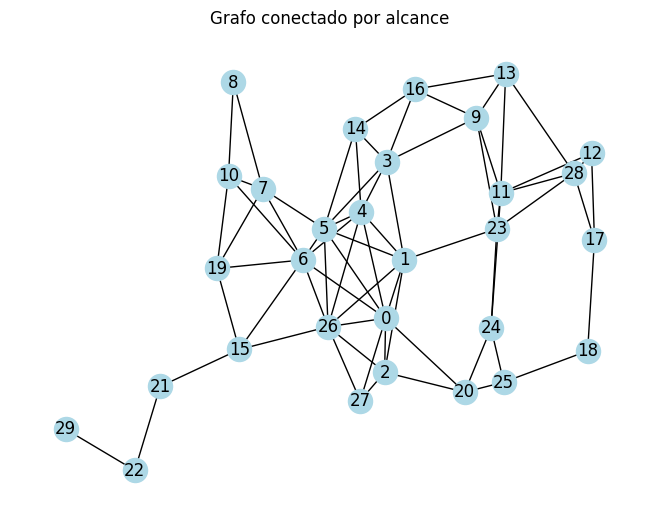

Nó 1 atualizou seu Rank para 1 (Pai: 0)
Nó 2 atualizou seu Rank para 1 (Pai: 0)
Nó 4 atualizou seu Rank para 1 (Pai: 0)
Nó 5 atualizou seu Rank para 1 (Pai: 0)
Nó 6 atualizou seu Rank para 1 (Pai: 0)
Nó 20 atualizou seu Rank para 1 (Pai: 0)
Nó 26 atualizou seu Rank para 1 (Pai: 0)
Nó 27 atualizou seu Rank para 1 (Pai: 0)
Nó 3 atualizou seu Rank para 2 (Pai: 1)
Nó 23 atualizou seu Rank para 2 (Pai: 1)
Nó 14 atualizou seu Rank para 2 (Pai: 4)
Nó 7 atualizou seu Rank para 2 (Pai: 5)
Nó 10 atualizou seu Rank para 2 (Pai: 6)
Nó 15 atualizou seu Rank para 2 (Pai: 6)
Nó 19 atualizou seu Rank para 2 (Pai: 6)
Nó 24 atualizou seu Rank para 2 (Pai: 20)
Nó 25 atualizou seu Rank para 2 (Pai: 20)
Nó 9 atualizou seu Rank para 3 (Pai: 3)
Nó 16 atualizou seu Rank para 3 (Pai: 3)
Nó 11 atualizou seu Rank para 3 (Pai: 23)
Nó 28 atualizou seu Rank para 3 (Pai: 23)
Nó 8 atualizou seu Rank para 3 (Pai: 7)
Nó 21 atualizou seu Rank para 3 (Pai: 15)
Nó 18 atualizou seu Rank para 3 (Pai: 25)
Nó 13 atualizou seu

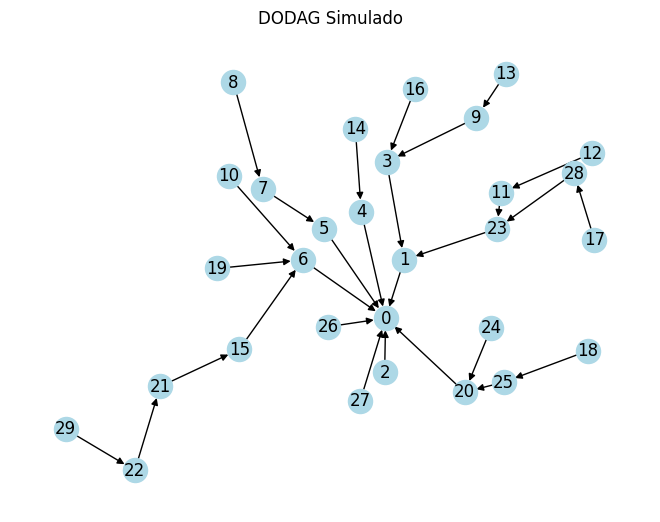

In [3]:
import random
import networkx as nx
import matplotlib.pyplot as plt

class Node:
    def __init__(self, node_id, position, is_root=False):
        self.node_id = node_id
        self.position = position
        self.is_root = is_root
        self.rank = 0 if is_root else float('inf')  # Rank inicial (0 para a raiz)
        self.parent = None
        self.neighbors = []

    def receive_dio(self, sender):
        """Processa uma mensagem DIO de um vizinho."""
        new_rank = sender.rank + 1  # Métrica simples: número de saltos
        if new_rank < self.rank:  # Atualiza se o novo caminho for melhor
            self.rank = new_rank
            self.parent = sender
            print(f"Nó {self.node_id} atualizou seu Rank para {self.rank} (Pai: {sender.node_id})")

class Network:
    def __init__(self, num_nodes, area_size, radius_of_reach):
        self.nodes = []
        self.graph = nx.Graph()
        self.area_size = area_size
        self.num_nodes = num_nodes
        self.radius_of_reach = radius_of_reach

    def create_network(self):
        """Cria nós e estabelece vizinhança com base na distância."""
        for i in range(self.num_nodes):
            node = self.generate_valid_node_with_neighborwood(id=i)
            self.nodes.append(node)
            self.graph.add_node(i, pos=node.position)

        # Estabelece conexões com base em distância
        for node in self.nodes:
            for neighbor in self.nodes:
                if node != neighbor and self.distance(node, neighbor) < self.radius_of_reach:
                    node.neighbors.append(neighbor)
                    self.graph.add_edge(node.node_id, neighbor.node_id)
        
        self.plot("Grafo conectado por alcance")
        
    def generate_valid_node_with_neighborwood (self, id):
        "Gera node e garante que tenha vizinhos no raio de alcance"
        position = (random.randint(0, self.area_size), random.randint(0, self.area_size))
        node = Node(node_id=id, position=position, is_root=(id==0))
        if not node.is_root:
            not_neighbor = True
            while not_neighbor:
                for n in self.nodes:
                    if self.distance(n, node) < self.radius_of_reach:
                        not_neighbor = False
                        break
                if not_neighbor:
                    position = (random.randint(0, self.area_size), random.randint(0, self.area_size))
                    node = Node(node_id=node.node_id, position=position, is_root=False)
                
        return node 

    def distance(self, node_a, node_b):
        """Calcula a distância euclidiana entre dois nós."""
        x1, y1 = node_a.position
        x2, y2 = node_b.position
        return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

    def propagate_dio(self):
        """Simula a propagação de mensagens DIO a partir da raiz."""
        queue = [self.nodes[0]]  # Começa com a raiz
        visited = set()  # Conjunto de nós visitados

        while queue:
            current = queue.pop(0)  # Retira o primeiro nó da fila
            if current.node_id in visited:
                continue  # Evita processar novamente

            visited.add(current.node_id)  # Marca o nó como visitado

            for neighbor in current.neighbors:
                if neighbor.node_id not in visited:  # Processa apenas não visitados
                    neighbor.receive_dio(current)
                    queue.append(neighbor)  # Adiciona à fila

    def visualize(self):
        """Visualiza o DODAG como um digrafo com setas."""
        digraph = nx.DiGraph()  # Digrafo para representar o DODAG

        # Adiciona os nós e arestas dirigidas com base no parent
        for node in self.nodes:
            digraph.add_node(node.node_id, pos=node.position)
            if node.parent is not None:
                digraph.add_edge(node.node_id, node.parent.node_id)

        # Recupera as posições para a plotagem
        pos = nx.get_node_attributes(digraph, 'pos')

        # Plota o digrafo com setas
        nx.draw(digraph, pos, with_labels=True, node_size=300, node_color='lightblue', arrows=True)
        plt.title("DODAG Simulado")
        plt.show()

        
    def plot(self, title):
        """Auxiliar para plot de grafos"""
        pos = nx.get_node_attributes(self.graph, 'pos')
        nx.draw(self.graph, pos, with_labels=True, node_size=300, node_color='lightblue')
        plt.title(title)
        plt.show()

# Parâmetros da rede
num_nodes = 30
area_size = 1000
radius_of_reach = 100

# Criação e simulação da rede
network = Network(num_nodes, area_size, radius_of_reach)
network.create_network()
network.propagate_dio()
network.visualize()
